# Creek

1. Blacken some cells of the grid resp. 
2. A number in a circle indicates how many of the 4 adjacent cells must be blackened.
3. All white cells must form a single orthogonally contiguous area.

-----

1. 将网格的某些单元格涂黑.
2. 圆圈中的数字表示 4 个相邻单元格中有多少个必须变黑。
3. 所有白细胞必须形成一个正交连续的区域。

In [12]:

import numpy as np
from ortools.sat.python import cp_model as cp
import gurobipy as gp
from collections import deque
from itertools import chain

In [13]:
def readGrid(path):
    with open(f"../assets/data/creek/{path}.txt") as f:
        num = f.readline()
        m, n = num.split(" ")[0], num.split(" ")[1]
        grid = f.readlines()
        res = [g.strip().split(" ") for g in grid]
        return int(m), int(n), res

if __name__ == "__main__":
    m, n, grid = readGrid("7x7_1")
    for g in grid:
        print(g)

['.', '.', '2', '.', '1', '.', '.', '0']
['2', '3', '.', '.', '.', '2', '.', '1']
['.', '.', '1', '.', '3', '.', '.', '.']
['1', '.', '.', '1', '.', '1', '.', '1']
['.', '2', '1', '.', '2', '.', '2', '.']
['.', '.', '.', '1', '.', '2', '.', '.']
['2', '.', '2', '.', '2', '.', '.', '0']
['1', '2', '2', '1', '.', '.', '1', '0']


In [14]:
def CreekSolver(m, n, grid) :
    """_summary_

    Args:
        m (_type_): # of rows
        n (_type_): # of cols
        grid (_type_): the grid
    """
    
    Creek = gp.Model("Creek")
    Creek.modelSense = gp.GRB.MAXIMIZE
    Creek.Params.lazyConstraints = 1
    Creek.update()
    x = {}
    for i in range(m):
        for j in range(n):
            x[i, j] = Creek.addVar(
            vtype = gp.GRB.BINARY,
            obj = 1,
            name = f"x[{i},{j}]")
            
    for i in range(m + 1):
        for j in range(n + 1):
            if grid[i][j] != ".":
                neighbours = []
                directions = [(-1, -1), (-1, 0), (0, -1), (0, 0)]
                for (subx, suby) in directions:
                    if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                        neighbours.append((i + subx, j + suby))
                Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) == int(grid[i][j]), name = f"constr_{i}_{j}_{grid[i][j]}")

    for i in range(m):
        for j in range(n):
            neighbours = []
            directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
            for (subx, suby) in directions:
                if (i + subx >= 0 and i + subx < m) and (j + suby >= 0 and j + suby < n):
                    neighbours.append((i + subx, j + suby))
            Creek.addConstr(gp.quicksum(x[subx, suby] for (subx, suby) in neighbours) <= len(neighbours) - 1 + x[i, j], name = f"alone_{i}_{j}")
    
    Creek.setObjective(gp.quicksum(x[i, j] for i in range(m) for j in range(n)), gp.GRB.MAXIMIZE)
    # Creek.setObjective(10, gp.GRB.MAXIMIZE)
    # Creek.write("Creek.lp")
    def border_elim(model, where):
        if (where == gp.GRB.Callback.MIPSOL):
            x_sol = model.cbGetSolution(model._x)
            curr_grid = [[0] * n for i in range(m)]
            for i in range(m):
                for j in range(n):
                    if int(x_sol[i, j]) == 0:
                        curr_grid[i][j] = 1
                
            def find_surrounding_black_cells(grid):
                rows, cols = len(grid), len(grid[0])
                visited = set()
                directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, down, left, right movements
                total_white = sum(chain.from_iterable(grid))
                # Find the first unvisited white cell
                def find_unvisited_white():
                    for i in range(rows):
                        for j in range(cols):
                            if grid[i][j] == 1 and (i, j) not in visited:
                                return (i, j)
                    return None
                borders_cut = [] # record cells that formulate the border: list(tuple)
                cells_inside_borders = [] # record all cells inside the border: list(tuple)
                cnt_white = 0
                while len(visited) < total_white:
                    start = find_unvisited_white()
                    if not start:
                        break
                    # Use BFS to find all connected white cells and record the surrounding black cells
                    queue = deque([start])
                    surrounding_black_cells = set()  # Use a set to avoid duplicates
                    current_inside_cells = [] # record cells in current border
                    while queue:
                        x, y = queue.popleft()
                        if (x, y) in visited:
                            continue
                        visited.add((x, y))
                        current_inside_cells.append((x, y))
                        cnt_white += 1
                        # Check all four adjacent directions
                        for dx, dy in directions:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < rows and 0 <= ny < cols:
                                if grid[nx][ny] == 1 and (nx, ny) not in visited:
                                    queue.append((nx, ny))
                                elif grid[nx][ny] == 0:
                                    surrounding_black_cells.add((nx, ny))
                    borders_cut.append(list(surrounding_black_cells))
                    cells_inside_borders.append(current_inside_cells)
                    
                assert len(borders_cut) == len(cells_inside_borders)

                if cnt_white == sum(chain.from_iterable(grid)) and len(borders_cut) == 1:
                    return [], []
                # borders_cut.sort(key = lambda x: len(x), reverse = True)
                return borders_cut, cells_inside_borders

            borders_cut, cells_inside_borders = find_surrounding_black_cells(curr_grid)

            for borders, cells_inside in zip(borders_cut, cells_inside_borders):
                if len(cells_inside) < m * n // 2:
                    for (cell_x, cell_y) in cells_inside:
                        model.cbLazy(gp.quicksum(model._x[subx, suby] for (subx, suby) in borders ) <= len(borders) - 1 + model._x[cell_x, cell_y])
                    
                
    Creek._x = x
    Creek.optimize(border_elim)
    # Creek.computeIIS()
    # Creek.write("Creek.ilp")
    
    for i in range(m):
        for j in range(n):
            if x[i, j].x > 1e-6:
                print(f"X", end = " ")
            else:
                print(f".", end = " ")
        print()
    print()

    
if __name__ == "__main__":
    m, n, grid = readGrid("20x30_1")
    # 20x30: No. 367
    # 19x19: No. 391
    # 19x24: No. 392
    CreekSolver(m, n, grid)
    

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 872 rows, 600 columns and 3939 nonzeros
Model fingerprint: 0x6e37511d
Variable types: 0 continuous, 600 integer (600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 694 rows and 395 columns
Presolve time: 0.01s
Presolved: 178 rows, 205 columns, 617 nonzeros
Variable types: 0 continuous, 205 integer (205 binary)

Root relaxation: objective 3.247500e+02, 113 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  324.75000    0    5          -  324.75000      -     -    0s


     0     0  318.25000    0   69          -  318.25000      -     -    0s
     0     0  316.37500    0   69          -  316.37500      -     -    0s
     0     0  316.33333    0   69          -  316.33333      -     -    0s
     0     0  313.75000    0   59          -  313.75000      -     -    0s
     0     0  313.75000    0   58          -  313.75000      -     -    0s
     0     0  313.00000    0    -          -  313.00000      -     -    0s
     0     0  311.75000    0   80          -  311.75000      -     -    0s
     0     0  311.64167    0   92          -  311.64167      -     -    0s
     0     2  311.39167    0   95          -  311.39167      -     -    0s
* 2607     1              14     268.0000000  269.00000  0.37%   4.0    1s

Cutting planes:
  Gomory: 4
  Clique: 15
  MIR: 11
  Zero half: 1
  RLT: 3
  Lazy constraints: 12917

Explored 2610 nodes (10968 simplex iterations) in 1.69 seconds (1.28 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 

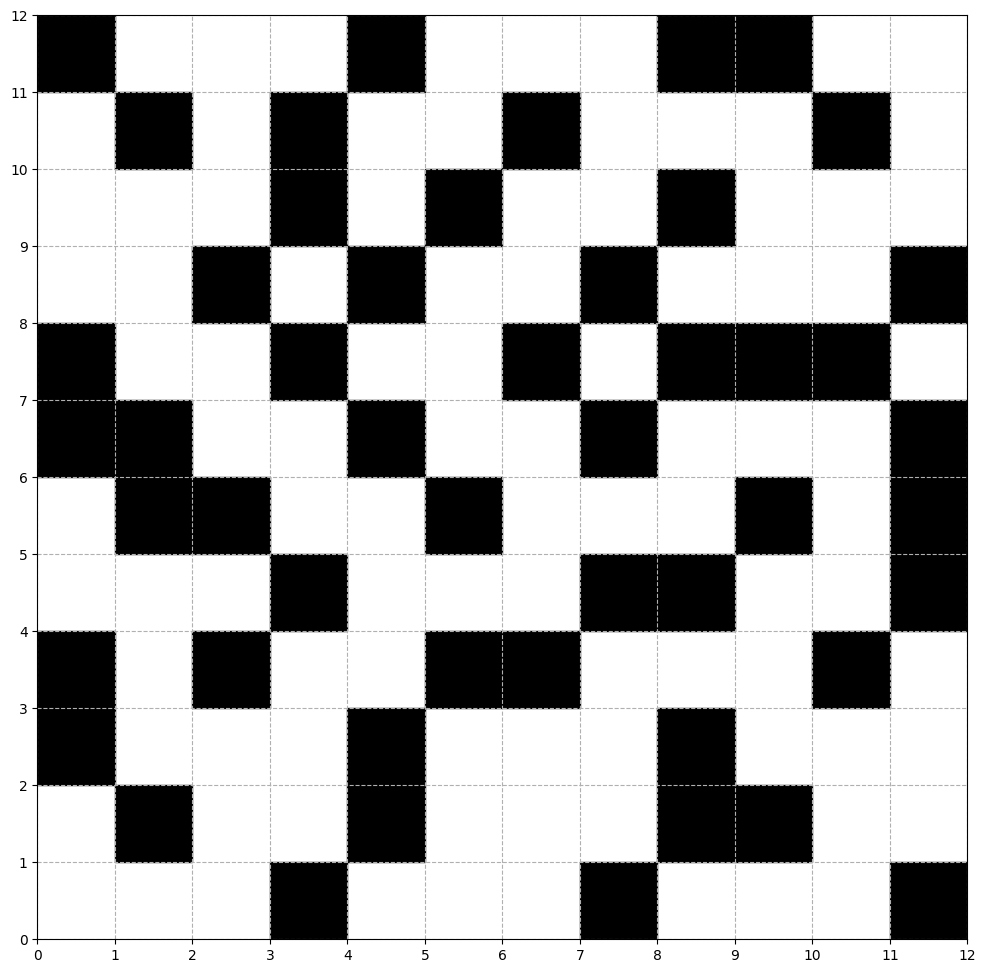

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import MultipleLocator

def showGrid(x, y, patches):
    plt.figure(figsize = (x, y))
    ax = plt.gca()
    x_major_locator = MultipleLocator(1)
    y_major_locator = MultipleLocator(1)
    ax.xaxis.set_major_locator(x_major_locator)
    # 把x/y轴的主刻度设置为1的倍数
    ax.yaxis.set_major_locator(y_major_locator)
    plt.xlim(0,y)
    plt.ylim(0,x)
    plt.grid(linestyle = "--")
    # patches = [(4, 0), (3, 4), (4, 3), (4, 9), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (8, 0), (9, 8), (8, 6), (10, 9), (1, 6), (0, 8), (2, 5), (1, 3), (11, 11), (2, 8), (6, 2), (7, 7), (6, 5), (6, 11), (5, 0), (4, 8), (8, 2), (8, 5), (9, 4), (11, 7), (0, 4), (10, 8), (6, 1), (7, 3), (3, 2), (3, 11), (4, 10), (9, 0), (5, 11), (0, 0), (10, 4), (1, 1), (11, 3), (10, 1), (8, 10), (0, 9), (2, 3), (1, 10), (7, 11), (6, 9), (7, 8)]
    for (xx, yy ) in patches:
            ax.add_patch(Rectangle((yy, x - 1 - xx), 1, 1, color = "#000000"))
    plt.show()

if __name__ == "__main__":
    patches = [(4, 0), (3, 4), (4, 3), (4, 9), (3, 7), (5, 4), (4, 6), (5, 1), (5, 7), (8, 0), (9, 8), (8, 6), (10, 9), (1, 6), (0, 8), (2, 5), (1, 3), (11, 11), (2, 8), (6, 2), (7, 7), (6, 5), (6, 11), (5, 0), (4, 8), (8, 2), (8, 5), (9, 4), (11, 7), (0, 4), (10, 8), (6, 1), (7, 3), (3, 2), (3, 11), (4, 10), (9, 0), (5, 11), (0, 0), (10, 4), (1, 1), (11, 3), (10, 1), (8, 10), (0, 9), (2, 3), (1, 10), (7, 11), (6, 9), (7, 8)]
    showGrid(12, 12, patches)